In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/models2/resnet_model.pk1
/kaggle/input/models2/vgg_model.pk1
/kaggle/input/gtsrb-german-traffic-sign/Meta.csv
/kaggle/input/gtsrb-german-traffic-sign/Train.csv
/kaggle/input/gtsrb-german-traffic-sign/Test.csv
/kaggle/input/gtsrb-german-traffic-sign/Meta/37.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/35.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/11.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/31.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/4.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/40.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/33.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/9.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/.~lock.ClassesInformation.ods#
/kaggle/input/gtsrb-german-traffic-sign/Meta/14.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/1.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/39.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/20.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/38.png
/kaggle/input/gtsrb-german-t

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam

import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image

import joblib

from sklearn.metrics import accuracy_score

import cv2

import random as rn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_path = '/kaggle/input/gtsrb-german-traffic-sign'
train_path = os.path.join(data_path,'Train')
test_path = os.path.join(data_path, 'Test')

train_df = pd.read_csv(data_path + '/Train.csv')
test_df = pd.read_csv(data_path + '/Test.csv')

In [4]:
train_df.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png

In [5]:
test_df.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png

In [6]:
height = 50
width = 50
batch_size = 150
seed = 42

In [7]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons'
          }

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)
train_data = train_datagen.flow_from_directory(train_path,
                                              target_size = (height,width),
                                              batch_size = batch_size,
                                              seed = seed,
                                              shuffle = True,
                                              class_mode = 'categorical',
                                              color_mode = 'rgb',
                                              interpolation = 'hamming',
                                              subset = 'training') 

Found 31368 images belonging to 43 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)
test_data = test_datagen.flow_from_directory(train_path,
                                              target_size = (height,width),
                                              batch_size = batch_size,
                                              seed = seed,
                                              shuffle = True,
                                              class_mode = 'categorical',
                                              color_mode = 'rgb',
                                              interpolation = 'hamming',
                                              subset = 'validation') 

Found 7841 images belonging to 43 classes.


In [10]:
vgg_model = Sequential([VGG16(weights = 'imagenet',
                              include_top = False, 
                             input_shape = (height,width,3)),
                       keras.layers.BatchNormalization(),
                       Flatten(),
                       Dense(512, activation = 'relu'),
                       Dense(43, activation = 'softmax')
                       ])
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 1, 1, 512)         2048      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 43)                22059     
                                                                 
Total params: 15001451 (57.23 MB)
Trainable params: 15000

In [11]:
resnet_model = Sequential([ResNet50V2(weights = 'imagenet',
                                     include_top = False,
                                     input_shape = (height,width,3)),
                          keras.layers.BatchNormalization(),
                          keras.layers.GlobalAveragePooling2D(),
                          Dense(512, activation = 'relu'),
                          Dense(43, activation = 'softmax')
                          ])
resnet_model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 batch_normalization_1 (Bat  (None, 2, 2, 2048)        8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 43)                22059     
                                                       

In [12]:
lr = 0.001
epochs = 25

In [13]:
vgg_model.compile(optimizer = Adam(learning_rate = lr,),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
resnet_model.compile(optimizer = Adam(learning_rate = lr,),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

In [14]:
vgg_run = vgg_model.fit(train_data,
                       steps_per_epoch = len(train_data),
                       epochs = epochs,
                       validation_data = test_data,
                       validation_steps = len(test_data))

vgg_file = "vgg_model.pk1"
joblib.dump(vgg_run, vgg_file)

Epoch 1/25
210/210 [==============================] - 230s 1s/step - loss: 2.5668 - accuracy: 0.2444 - val_loss: 16.7886 - val_accuracy: 0.0930
Epoch 2/25
210/210 [==============================] - 42s 201ms/step - loss: 0.8504 - accuracy: 0.7262 - val_loss: 25.3631 - val_accuracy: 0.0729
Epoch 3/25
210/210 [==============================] - 43s 206ms/step - loss: 0.2648 - accuracy: 0.9201 - val_loss: 9.6942 - val_accuracy: 0.1161
Epoch 4/25
210/210 [==============================] - 42s 197ms/step - loss: 0.1178 - accuracy: 0.9648 - val_loss: 1.7133 - val_accuracy: 0.5791
Epoch 5/25
210/210 [==============================] - 42s 200ms/step - loss: 0.0690 - accuracy: 0.9798 - val_loss: 0.4428 - val_accuracy: 0.8774
Epoch 6/25
210/210 [==============================] - 42s 201ms/step - loss: 0.0574 - accuracy: 0.9823 - val_loss: 1.0381 - val_accuracy: 0.7735
Epoch 7/25
210/210 [==============================] - 41s 196ms/step - loss: 0.0350 - accuracy: 0.9896 - val_loss: 0.5694 - val_ac

['vgg_model.pk1']

In [15]:
resnet_run = resnet_model.fit(train_data,
                             steps_per_epoch = len(train_data),
                             epochs = epochs,
                             validation_data = test_data,
                             validation_steps = len(test_data))
resnet_file = "resnet_model.pk1"
joblib.dump(resnet_run, resnet_file)

Epoch 1/25
210/210 [==============================] - 81s 226ms/step - loss: 0.4075 - accuracy: 0.8818 - val_loss: 0.3528 - val_accuracy: 0.9059
Epoch 2/25
210/210 [==============================] - 43s 202ms/step - loss: 0.0577 - accuracy: 0.9833 - val_loss: 0.3330 - val_accuracy: 0.9172
Epoch 3/25
210/210 [==============================] - 42s 200ms/step - loss: 0.0399 - accuracy: 0.9890 - val_loss: 0.3420 - val_accuracy: 0.9054
Epoch 4/25
210/210 [==============================] - 42s 201ms/step - loss: 0.0454 - accuracy: 0.9873 - val_loss: 0.4989 - val_accuracy: 0.8991
Epoch 5/25
210/210 [==============================] - 42s 198ms/step - loss: 0.0339 - accuracy: 0.9906 - val_loss: 0.2956 - val_accuracy: 0.9265
Epoch 6/25
210/210 [==============================] - 42s 197ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.2806 - val_accuracy: 0.9328
Epoch 7/25
210/210 [==============================] - 42s 199ms/step - loss: 0.0130 - accuracy: 0.9962 - val_loss: 0.7384 - val_ac

['resnet_model.pk1']

In [16]:
vgg_performance = pd.DataFrame(vgg_run.history)
resnet_performance = pd.DataFrame(resnet_run.history)

In [17]:
fig = make_subplots(rows=3, cols=2, subplot_titles=("Model Accuracy", "Model Loss"))

In [18]:
#vgg plot
fig.add_trace(go.Scatter(x = vgg_performance.index,
                        y = vgg_performance['accuracy'],
                        mode = 'lines',
                        name = 'VGG16 Training Accuracy'),
             row=1, col=1)
fig.add_trace(go.Scatter(x = vgg_performance.index,
                        y = vgg_performance['val_accuracy'],
                        mode = 'lines',
                        name = 'VGG16 Validation Accuracy'),
             row=1, col=1)
fig.add_trace(go.Scatter(x = vgg_performance.index,
                        y = vgg_performance['loss'],
                        mode = 'lines',
                        name = 'VGG16 Training Loss'),
             row=1, col=2)
fig.add_trace(go.Scatter(x = vgg_performance.index,
                        y = vgg_performance['val_loss'],
                        mode = 'lines',
                        name = 'VGG16 Validation Loss'),
             row=1, col=2)
#resnet plot
fig.add_trace(go.Scatter(x = resnet_performance.index,
                        y = resnet_performance['accuracy'],
                        mode = 'lines',
                        name = 'Resnet50V2 Training Accuracy'),
             row=2, col=1)
fig.add_trace(go.Scatter(x = resnet_performance.index,
                        y = resnet_performance['val_accuracy'],
                        mode = 'lines',
                        name = 'Resnet50V2 Validation Accuracy'),
             row=2, col=1)
fig.add_trace(go.Scatter(x = resnet_performance.index,
                        y = resnet_performance['loss'],
                        mode = 'lines',
                        name = 'Resnet50V2 Training Loss'),
             row=2, col=2)
fig.add_trace(go.Scatter(x = resnet_performance.index,
                        y = resnet_performance['val_loss'],
                        mode = 'lines',
                        name = 'Resnet50V2 Validation Loss'),
             row=2, col=2)
fig.update_xaxes(title_text = 'Epochs', row=2, col=1)
fig.update_yaxes(title_text = 'Accuracy', range=[0,1],row=2, col=1)
fig.show()

In [19]:
def map_pred(pred):
    return[int(list(train_data.class_indices.keys())[i])for i in pred]

In [20]:
test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data=[]

for img in imgs:
    image = cv2.imread(data_path + '/' +img)
    img_fromarray = Image.fromarray(image, 'RGB')
    resize_image = img_fromarray.resize((height,width))
    data.append(np.array(resize_image))
    
X_test = np.array(data)
X_test = X_test/255

In [21]:
vgg_pred = vgg_model.predict(X_test)
vgg_pred = map_pred(vgg_pred.argmax(axis = -1))

395/395 [==============================] - 6s 12ms/step


In [22]:
resnet_pred = resnet_model.predict(X_test)
resnet_pred = map_pred(resnet_pred.argmax(axis = -1))

395/395 [==============================] - 7s 13ms/step


In [23]:
vgg_test_acc = accuracy_score(test_labels, vgg_pred) 
resnet_test_acc = accuracy_score(test_labels, resnet_pred) 

In [24]:
vgg_test_acc

0.6915281076801267

In [25]:
resnet_test_acc

0.8036421219319082

5/5 [==============================] - 0s 16ms/step


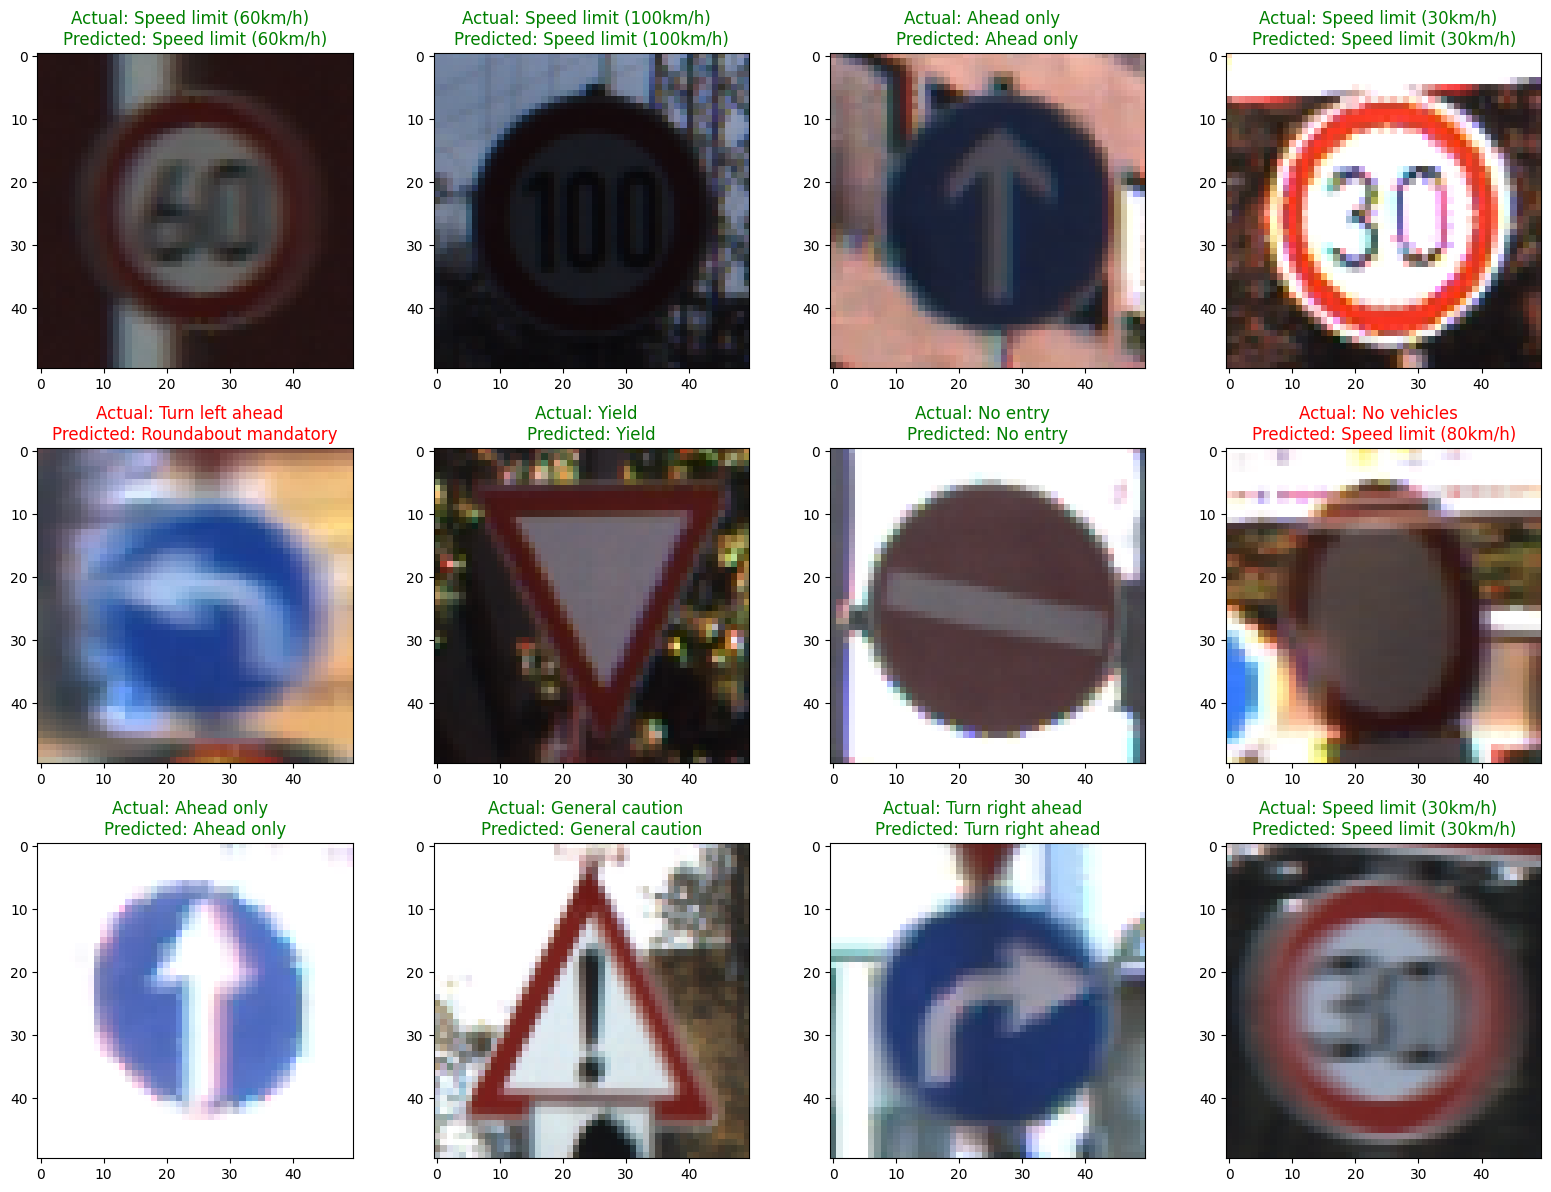

In [26]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_data.next()
predicted = vgg_model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

5/5 [==============================] - 0s 20ms/step


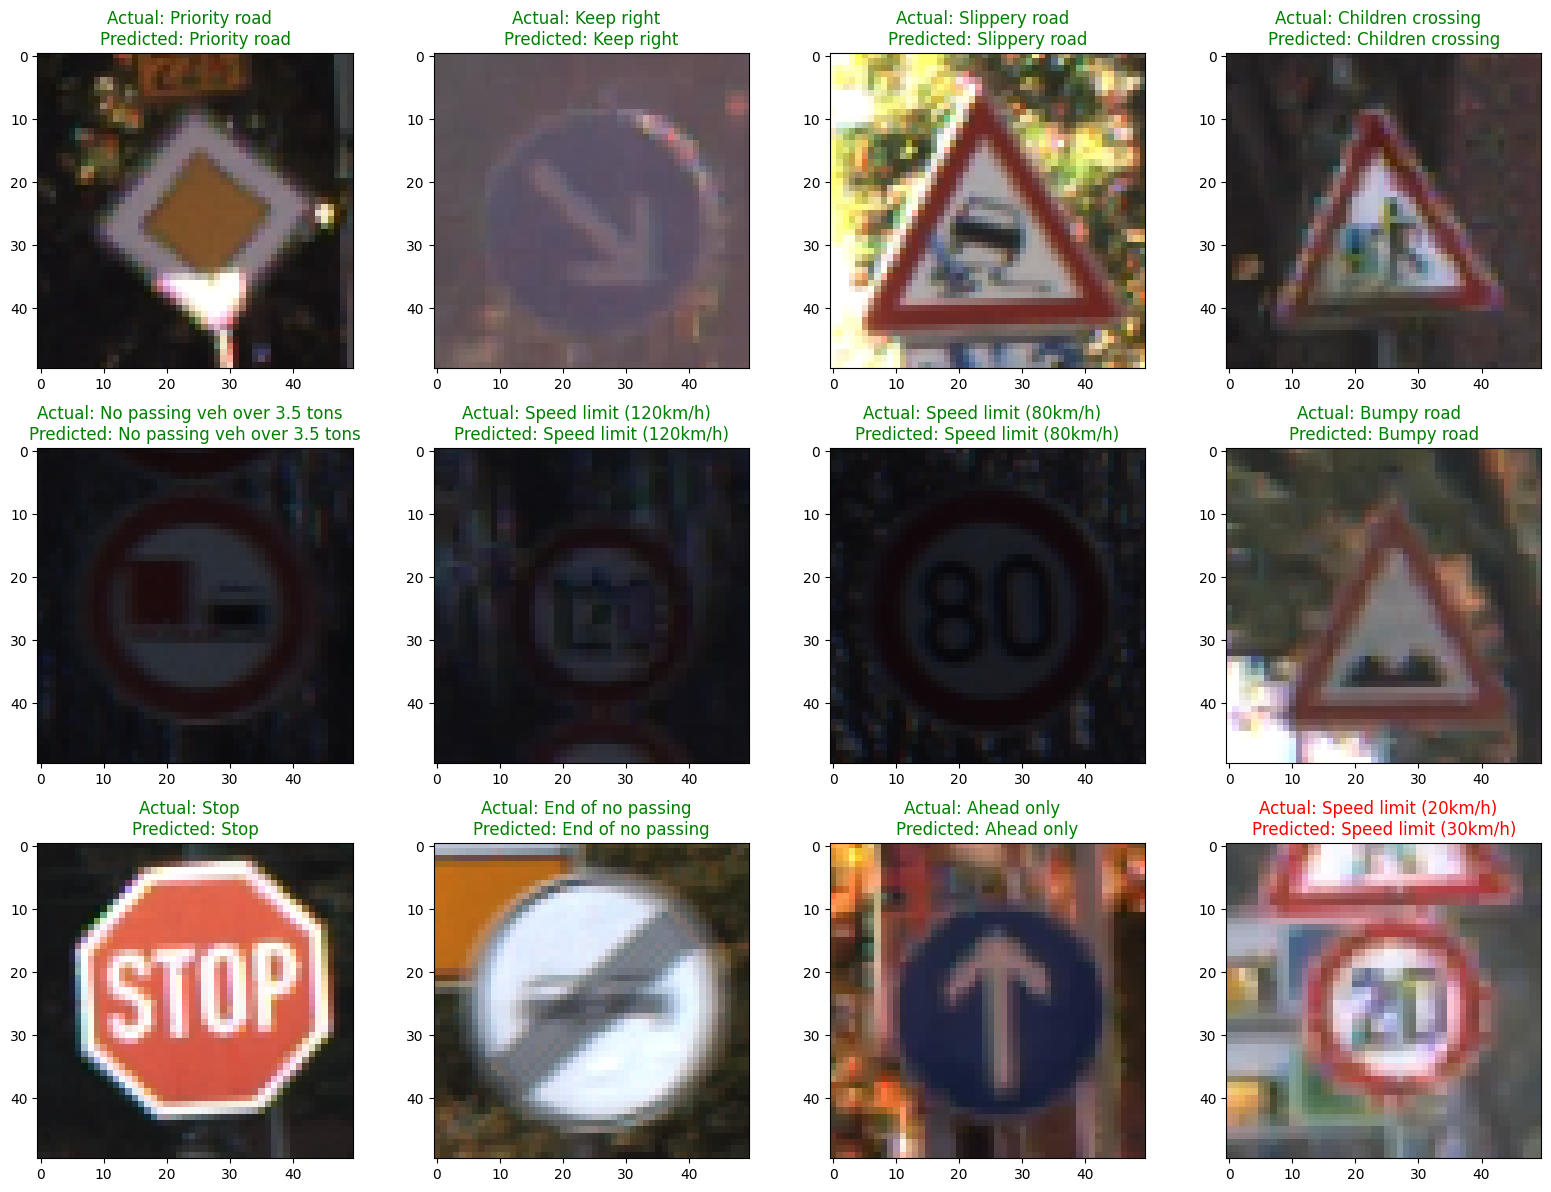

In [27]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_data.next()
predicted = resnet_model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()